<h1> Gaussian Processes for inequalities </h1>

Using Gaussian Process regression to fit top 1% income share to countries without data

In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Preprocessing </h2>

We want to map top incomes. We will make the strong assumption that top incomes are only a spatial effect.

Our design matrix <b> X </b> will be the latitude and longitude of each country's centroid, and the targets <b> y </b> will be the top percentile income

Geopandas has the centroid data

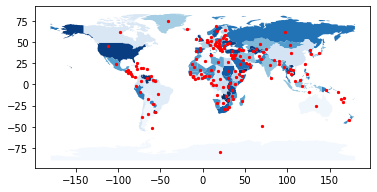

In [46]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# assuming geographical centroid, not population weighted
centroids_df = pd.concat([world.name, world.centroid, world.centroid.x, world.centroid.y], axis=1)
centroids_df.columns = ["Country", "centroid", "centroid x", "centroid y"]
world.centroid.plot(ax = world.plot(column = "name", cmap = 'Blues'), marker = 'o', color = 'red', markersize = 5)
plt.show()

Top 1% income for all countries with data in 2017 from WID.world

In [11]:
income_df = pd.read_csv("wid_1pc.csv", skiprows = 1, sep = ";")
income_df.columns = ["Country", "percentile", "Income p99p100"]
income_df = income_df[["Country", "Income p99p100"]]
income_df["Country"] = income_df["Country"].str.strip() # remove whitespace
income_df = income_df.dropna() # Only keep regions with all 1pc data (90/124)

In [13]:
cent_inc_df = centroids_df.merge(income_df, on = "Country")
# We lose 14 more countries with this merge, but I do not want to check the spelling of all the countries in both datasets to check if they match
cent_inc_df

,Country,centroid,centroid x,centroid y,Income p99p100
0,Tanzania,POINT (34.75299 -6.25773),34.752990,-6.257732,0.161714
1,Somalia,POINT (45.72670 4.75235),45.726701,4.752348,0.169008
2,Kenya,POINT (37.79156 0.59597),37.791555,0.595966,0.150241
3,Sudan,POINT (29.86260 15.99059),29.862604,15.990585,0.111604
4,Chad,POINT (18.58133 15.32887),18.581330,15.328867,0.155934
...,...,...,...,...,...
71,Uganda,POINT (32.35755 1.29549),32.357550,1.295486,0.168541
72,Rwanda,POINT (29.91896 -2.01351),29.918964,-2.013514,0.196732
73,Macedonia,POINT (21.69790 41.60593),21.697903,41.605930,0.076600
74,Serbia,POINT (20.81965 44.23304),20.819652,44.233037,0.128000


<h2> Gaussian Process fitting </h2>

Train on the centroid coordinates where we have top percentile income data (from merged dataframe)

In [27]:
X_train = cent_inc_df[["centroid x", "centroid y"]]
y_train = cent_inc_df["Income p99p100"]

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

Using the scikit-learn implementation, we add three kernels:
<ul>
  <li>Contant kernel for amplitude factor</li>
  <li>Matérn kernel for length scale</li>
  <li>White kernel for noise model</li>
</ul>

In [19]:
kernel = ConstantKernel() + Matern(length_scale = 2, nu = 3/2) + WhiteKernel(noise_level = 1)
kernel.get_params() # prior parameters, constant kernel has amplitude 1

{'k1': 1**2 + Matern(length_scale=2, nu=1.5),
 'k2': WhiteKernel(noise_level=1),
 'k1__k1': 1**2,
 'k1__k2': Matern(length_scale=2, nu=1.5),
 'k1__k1__constant_value': 1.0,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 2,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k1__k2__nu': 1.5,
 'k2__noise_level': 1,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

In [28]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

We can see the posterior parameters

In [29]:
gp.kernel_

0.00417**2 + Matern(length_scale=1.45e+03, nu=1.5) + WhiteKernel(noise_level=0.000984)

Length scale seems very long at 1450 (latitude between -180 and 180). Could be underfitting?

<h2> Gaussian Process prediction </h2>
Apply this fitting to predict for all other countries that don't have data (from the geopandas centroid data)

In [25]:
X_test = centroids_df[["centroid x", "centroid y"]] # Predict for centroid of all world countries
y_test, sigma = gp.predict(X_test, return_std = True)

Compare model performance against true values

In [30]:
from sklearn.metrics import mean_squared_error
mean_squared_error(cent_inc_df["Income p99p100"], gp.predict(X_train))

0.0009334697896056835

Firstly, plot the true case

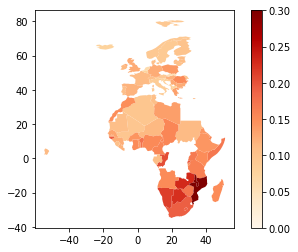

In [71]:
true_df = world.merge(income_df, left_on = "name", right_on = "Country")
true_df.plot(column = "Income p99p100", cmap = "OrRd", legend = True, vmin = 0, vmax = 0.3)
plt.show()

And now the predicted top incomes

In [63]:
pred_df = world.copy()
pred_df["Income p99p100 GP"] = y_test
pred_df["ci95"] = sigma*1.96 # 95% confidence intervals GP", cmap = "hot", legend=True, vmin=0, vmax=0.3, cax = divider.append_axes("right", size="5%", pad=0.1))
#plt.figure(figsize = (20,30), ax = ax)
plt.show()

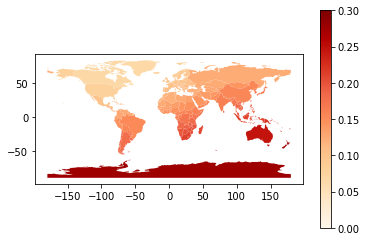

In [67]:
pred_df.plot(column = "Income p99p100 GP", cmap = "OrRd", legend = True, vmin = 0, vmax = 0.3)
plt.show()

What we can see is that most of the merged data came from Europe (more equal) and Africa (less equal). Thus, the GP fitted with a long length scale with the trend being that the top percentile in Europe have a lower share than in Africa, with the trend heading southeastward.

Hence, the fit predicts USA as very equal and Antartica as the most plutocratic country in the world -- perhaps this isn't true?

However, the advantage of the Bayesian GP method is that we get error estimates. Large errors associated with countries without nearby data...

In [86]:
pred_df.loc[pred_df["Income p99p100 GP"].idxmin()]

pop_est                                                          57713
continent                                                North America
name                                                         Greenland
iso_a3                                                             GRL
gdp_md_est                                                        2173
geometry             POLYGON ((-46.76379 82.62796, -43.40644 83.225...
Income p99p100 GP                                            0.0664666
ci95                                                         0.0779287
Name: 22, dtype: object

...whereas for the Democratic Republic of the Congo, a country surrounded by countries with data, there is a smaller error (and perhaps a better mean).

In [73]:
pred_df[pred_df["name"] == "United States of America"]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Income p99p100 GP,ci95
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.079046,0.129872


In [82]:
pred_df[pred_df["name"] == "Dem. Rep. Congo"]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Income p99p100 GP,ci95
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998...",0.171877,0.06254


This fitting attempt would be better if we had more data, but also if we had social and political data, which is a greater influence on income distribution than geography.